In [1]:
import pandas as pd
import torch
from kan import *

In [8]:
# df = pd.read_csv('solvents_properties.csv')
# df

In [2]:
torch.set_default_dtype(torch.float32)

# device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
device = 'cpu'
print(device)

cpu


In [3]:
from kan.utils import create_dataset
# create dataset f(x,y) = exp(sin(pi*x)+y^2)
f = lambda x: torch.exp(torch.sin(torch.pi*x[:,[0]]) + x[:,[1]]**2)
dataset = create_dataset(f, n_var=2) # device
dataset['train_input'].shape, dataset['train_label'].shape, dataset['test_input'].shape, dataset['test_label'].shape

(torch.Size([1000, 2]),
 torch.Size([1000, 1]),
 torch.Size([1000, 2]),
 torch.Size([1000, 1]))

In [11]:
# X = torch.tensor(df[['δd', 'δp', 'δh']].values.astype('float32')).to(device)
# y = torch.tensor(df['δT'].values.astype('float32')).to(device)

checkpoint directory created: ./model
saving model version 0.0


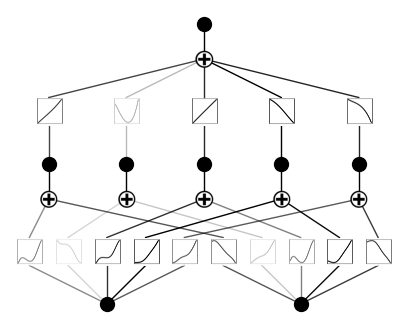

In [4]:
# create a KAN: 3D inputs, 1D output, and 5 hidden neurons. cubic spline (k=3), 5 grid intervals (grid=5).
model = KAN(width=[2,5,1], grid=3, k=3, seed=42, device=device)
model(dataset['train_input'])
model.plot()

In [5]:
from sklearn.model_selection import train_test_split

def generate_kan_dataset(X, y):
    """
    Generate dataset for kan.

    Args:
        X(nparray): tensor of train_input.
        y(nparray): tensor of train_label.
    Returns:
        dict: A dictionary containing train_input, train_label, test_input, test_label
    """

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    dataset = {'train_input': [], 'test_input': [], 'train_label': [], 'test_label': []}

    # Convert lists to tensors
    dataset['train_input'] = torch.tensor(X_train)
    dataset['test_input'] = torch.tensor(X_test)
    dataset['train_label'] = torch.tensor(y_train).reshape(-1, 1)
    dataset['test_label'] = torch.tensor(y_test).reshape(-1, 1)

    return dataset
dataset = generate_kan_dataset(dataset['train_input'], dataset['train_label'])
dataset

/var/folders/5_/gc6hmj2n29l66pvrzycbx1j80000gn/T/ipykernel_3963/353855115.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataset['train_input'] = torch.tensor(X_train)
/var/folders/5_/gc6hmj2n29l66pvrzycbx1j80000gn/T/ipykernel_3963/353855115.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataset['test_input'] = torch.tensor(X_test)
/var/folders/5_/gc6hmj2n29l66pvrzycbx1j80000gn/T/ipykernel_3963/353855115.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataset['train_label'] = torch.tensor(y_train).reshape(-1, 1)
/var/fold

{'train_input': tensor([[ 0.2216, -0.8879],
         [-0.9613,  0.2956],
         [-0.8237, -0.3119],
         ...,
         [ 0.6063,  0.0644],
         [-0.3583,  0.8328],
         [-0.4360, -0.0835]]),
 'test_input': tensor([[-0.2412,  0.3577],
         [-0.7314, -0.8769],
         [-0.7935,  0.0818],
         [-0.2507, -0.8161],
         [-0.1567,  0.9856],
         [ 0.6848, -0.0913],
         [ 0.8768,  0.7271],
         [-0.3728,  0.2715],
         [-0.9310,  0.7551],
         [ 0.0278,  0.8094],
         [-0.3455,  0.2001],
         [ 0.1990,  0.1745],
         [-0.3978, -0.3292],
         [ 0.6515,  0.1054],
         [ 0.7238,  0.6023],
         [ 0.2999,  0.2974],
         [ 0.0319,  0.3807],
         [ 0.9386,  0.0756],
         [ 0.5994, -0.9182],
         [ 0.0784, -0.1083],
         [ 0.9813,  0.1000],
         [-0.9025, -0.1619],
         [ 0.6944, -0.4546],
         [-0.2691, -0.7711],
         [-0.0074,  0.0991],
         [-0.6322,  0.7034],
         [ 0.6738,  0.0989]

In [6]:
def train_acc():
    return torch.mean((torch.round(model(dataset['train_input'])[:,0]) == dataset['train_label'][:,0]).float())

def test_acc():
    return torch.mean((torch.round(model(dataset['test_input'])[:,0]) == dataset['test_label'][:,0]).float())

In [7]:
# train the model
result = model.fit(dataset, opt="LBFGS", steps=50, lamb=0.001, metrics=(train_acc, test_acc))

| train_loss: 1.87e-02 | test_loss: 2.09e-02 | reg: 8.44e+00 | : 100%|█| 50/50 [00:04<00:00, 10.56it

saving model version 0.1


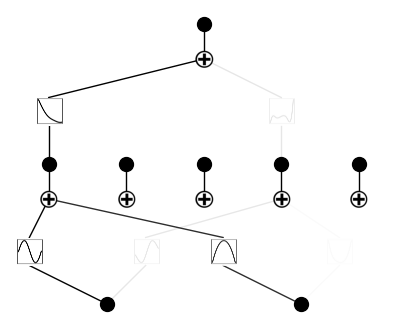

In [8]:
model.plot()

saving model version 0.2


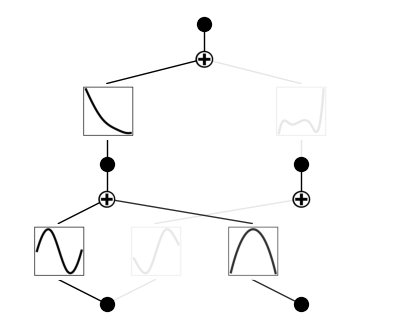

In [9]:
model = model.prune()
model.plot()

In [10]:
result = model.fit(dataset, opt="LBFGS", steps=50, lamb=0.001, metrics=(train_acc, test_acc))

| train_loss: 1.41e-02 | test_loss: 1.29e-02 | reg: 6.64e+00 | : 100%|█| 50/50 [00:02<00:00, 21.39it

saving model version 0.3


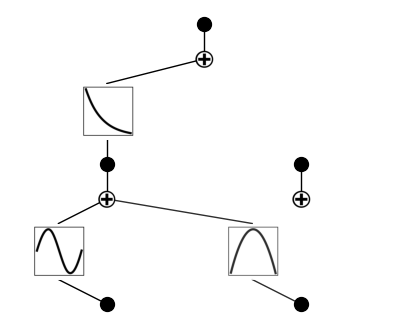

In [11]:
model.plot()

saving model version 0.4


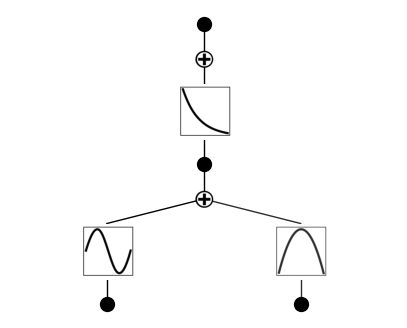

In [14]:
model = model.prune()
model.plot()

In [15]:
result = model.fit(dataset, opt="LBFGS", steps=50, lamb=0.001, metrics=(train_acc, test_acc))

| train_loss: 1.28e-02 | test_loss: 1.23e-02 | reg: 7.61e+00 | : 100%|█| 50/50 [00:02<00:00, 19.39it

saving model version 0.5


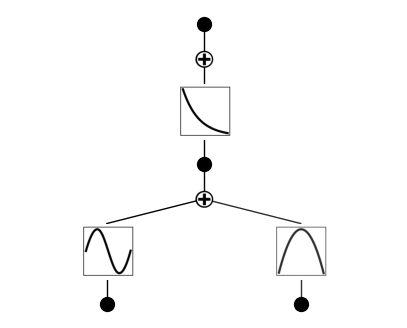

In [16]:
model.plot()

In [17]:
model = model.refine(10)

saving model version 0.6


In [19]:
result = model.fit(dataset, opt="LBFGS", steps=50, lamb=0.001, metrics=(train_acc, test_acc))

| train_loss: 1.14e-03 | test_loss: 1.07e-03 | reg: 7.61e+00 | : 100%|█| 50/50 [00:00<00:00, 58.30it

saving model version 0.8


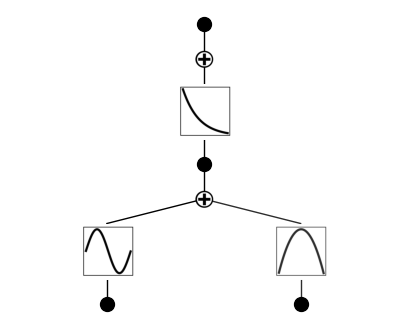

In [20]:
model.plot()

In [21]:
lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','abs']

model.auto_symbolic(lib=lib)

fixing (0,0,0) with sin, r2=0.9999990463256836, c=2
fixing (0,1,0) with x^2, r2=1.000000238418579, c=2
fixing (1,0,0) with exp, r2=1.0000003576278687, c=2
saving model version 0.9


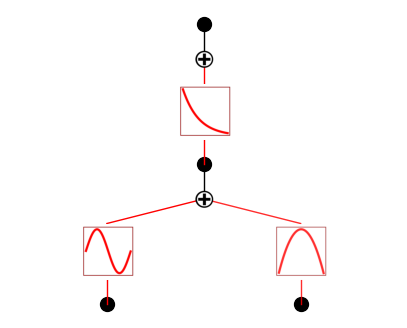

In [22]:
model.plot()

In [24]:
model.fit(dataset, opt="LBFGS", steps=50)

| train_loss: 1.28e-03 | test_loss: 1.31e-03 | reg: 0.00e+00 | : 100%|█| 50/50 [00:00<00:00, 89.57it

saving model version 0.11


{'train_loss': [array(0.00128438, dtype=float32),
  array(0.00128438, dtype=float32),
  array(0.00128439, dtype=float32),
  array(0.00128439, dtype=float32),
  array(0.00128439, dtype=float32),
  array(0.00128439, dtype=float32),
  array(0.00128439, dtype=float32),
  array(0.00128439, dtype=float32),
  array(0.00128439, dtype=float32),
  array(0.00128439, dtype=float32),
  array(0.00128439, dtype=float32),
  array(0.00128438, dtype=float32),
  array(0.00128439, dtype=float32),
  array(0.00128439, dtype=float32),
  array(0.00128439, dtype=float32),
  array(0.00128439, dtype=float32),
  array(0.00128439, dtype=float32),
  array(0.00128439, dtype=float32),
  array(0.00128439, dtype=float32),
  array(0.00128439, dtype=float32),
  array(0.00128439, dtype=float32),
  array(0.00128439, dtype=float32),
  array(0.00128439, dtype=float32),
  array(0.00128439, dtype=float32),
  array(0.00128439, dtype=float32),
  array(0.00128439, dtype=float32),
  array(0.00128439, dtype=float32),
  array(0.0012

In [25]:
from kan.utils import ex_round

result = ex_round(model.symbolic_formula()[0][0], 4)
result

0.995*exp(1.0019*x_2**2 + 1.003*sin(3.1409*x_1 + 0.0002)) + 0.0056

In [1]:
import math

math.sqrt((15.8)**2 + (8.8)**2 + (19.4)**2)

26.522443326360413

In [ ]:
# Given values
x1 = 15.8
x2 = 8.8
x3 = 9.4

# Calculate the result of the equation
result = (
    0.7931 * x1
    + 0.3564 * x2
    + 0.3495 * x3
    + 0.4249 * math.sin(1.2026 * x1 - 0.7399 * x2 + 1.3698 * x3 + 3.2397)
    + 1.8047
)

result
